# Part 1: Acquire compound data from ChEMBL

The aim of this in silico project is to present inhibitors with high potency of the BACE1 receptor. A higher potency of a drug means that the specific biological effect can be achieved with a smaller amount of the drug. For inhibitors this is often expressed in the IC50 value, this is the value at which 50% of the effect is inhibited. The IC50 value can be measured using a radioligand labelling assay, but the synthesis and measuring are time-consuming and expensive. The potency for the BACE1 receptor of a large amount of compounds has already been tested, and those data can be found in the publicly available ChEMBL database of the European Bioinformatics Institute. Therefore this project will use the already available data to train a machine learning model to predict which novel compound is  likely the most promising. 
The ChEMBL database contains more than one million bioactive molecules with drug-like properties, manually compiled and standardized from primary published literature. Therefore, this database is used to fetch known bioactivity data.

Import ChEMBL webresource client and other required libraries.

In [1]:
!pip install chembl_webresource_client

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

Define path to store data.

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Create the resource objects for API (Application Interface Programming) access the ChEMBL database.

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

## Get target data

The BACE1 receptor is selected as target. The UniProt database identifier of the BACE1 receptor is used for identification.

In [4]:
uniprot_id = "P56817" # Uniprot id for the BACE receptor

Get the needed target information from ChEMBL, using the API access

In [9]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)

In [10]:
targets = pd.DataFrame.from_records(targets) # Make a dataframe of the results, not sure why two identical targets show
targets

,cross_references,organism,pref_name,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Beta-secretase_1', 'xref_name': ...",Homo sapiens,Beta-secretase 1,False,CHEMBL4822,"[{'accession': 'P56817', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'Beta-secretase_1', 'xref_name': ...",Homo sapiens,Beta-secretase 1,False,CHEMBL4822,"[{'accession': 'P56817', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Homo sapiens,Beta-secretase (BACE),False,CHEMBL2111390,"[{'accession': 'Q9Y5Z0', 'component_descriptio...",PROTEIN FAMILY,9606


Select the right target, the BACE1 receptor of the human, with target_type 'single protein'

In [17]:
target = targets.iloc[0]
target

cross_references      [{'xref_id': 'Beta-secretase_1', 'xref_name': ...
organism                                                   Homo sapiens
pref_name                                              Beta-secretase 1
species_group_flag                                                False
target_chembl_id                                             CHEMBL4822
target_components     [{'accession': 'P56817', 'component_descriptio...
target_type                                              SINGLE PROTEIN
tax_id                                                             9606
Name: 0, dtype: object

Save the selected ChEMBL ID in the variable chembl_id, to later use for geting the bioactivity data of the receptor with this ChEMBL ID.

In [19]:
chembl_id = target.target_chembl_id

Check the target ChEMBL ID

In [20]:
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL4822


## Get bioactivity data

Fetch the wanted bioactivity data for the BACE receptor. Using the API access with the selected ChEMBL ID. This step only consider data that is binding data of exact measurements and with bioactivity type IC50. 

In [21]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 9513, <class 'chembl_webresource_client.query_set.QuerySet'>


To see what kind of information is in there, here is the information of the first entry shown:

In [22]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 45, <class 'dict'>


{'activity_comment': None,
 'activity_id': 78857,
 'activity_properties': [],
 'assay_chembl_id': 'CHEMBL653511',
 'assay_description': 'Inhibitory activity against Beta-secretase 1 was determined',
 'assay_type': 'B',
 'assay_variant_accession': None,
 'assay_variant_mutation': None,
 'bao_endpoint': 'BAO_0000190',
 'bao_format': 'BAO_0000357',
 'bao_label': 'single protein format',
 'canonical_smiles': 'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O)O)C(C)C)C(=O)N[C@@H](Cc1ccccc1)[C@@H](O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](Cc1ccccc1)C(=O)O',
 'data_validity_comment': None,
 'data_validity_description': None,
 'document_chembl_id': 'CHEMBL1136466',
 'document_journal': 'Bioorg. Med. Chem. Lett.',
 'document_year': 2003,
 'ligand_efficiency': {'bei': '6.39',
  'le': '0.12',
  'lle': '7.82',
  'sei': '1.60'},
 'molecule_chembl_id': 'CHEMBL406146',
 'molecule_pref_name': 'HGLUVALLEUPNSASPALAGLUPHEOH',
 'parent_molecule_chembl_id': 'CHEMBL406146',
 'pch

Read the bioactivity data from the queried ChEMBL webresource client

In [12]:
bioactivities_df = pd.DataFrame.from_records(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (9514, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50,nM,413.0
1,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50,nM,413.0
2,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50,uM,0.002
3,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50,uM,0.46
4,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50,uM,9.0


Keep only the standardized unit columns

In [13]:
bioactivities_df["units"].unique() # See if there are multiple units used

array(['nM', 'uM', 'M', 'mM', 'umol/L', 'microM', "10'-7M", "10'-8M"],
      dtype=object)

In [14]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head(n=12)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50
1,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50
2,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50
3,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50
4,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50
5,395859,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL419949,=,nM,5600.0,CHEMBL4822,Homo sapiens,IC50
6,397117,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL116826,=,nM,34000.0,CHEMBL4822,Homo sapiens,IC50
7,400254,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL143239,=,nM,20.0,CHEMBL4822,Homo sapiens,IC50
8,402256,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL332948,=,nM,21.0,CHEMBL4822,Homo sapiens,IC50
9,402257,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL51386,=,nM,300.0,CHEMBL4822,Homo sapiens,IC50


## Preprocess and filter bioactivity data

Covert types of variables

In [15]:
bioactivities_df.dtypes # See what the types are now

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [16]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"}) # Convert type of standard_value to float
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

Remove the entries with a missing values

In [17]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (9514, 11)


See if there are entries that do not have nM as standard_unit

In [18]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


Zero entries have a standard_unit other than nM. Thus, we can keep all data points.

Remove duplicate molecules

In [19]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6691, 11)


Reset the index

In [20]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50
1,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50
2,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50
3,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50
4,395859,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL419949,=,nM,5600.0,CHEMBL4822,Homo sapiens,IC50


Give the columns a proper name

In [21]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,78857,CHEMBL653511,Inhibitory activity against Beta-secretase 1 w...,B,CHEMBL406146,=,nM,413.0,CHEMBL4822,Homo sapiens,IC50
1,391560,CHEMBL653332,Compound was tested for its inhibitory activit...,B,CHEMBL78946,=,nM,2.0,CHEMBL4822,Homo sapiens,IC50
2,391983,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL324109,=,nM,460.0,CHEMBL4822,Homo sapiens,IC50
3,395858,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL114147,=,nM,9000.0,CHEMBL4822,Homo sapiens,IC50
4,395859,CHEMBL653512,Inhibition of human Beta-secretase 1,B,CHEMBL419949,=,nM,5600.0,CHEMBL4822,Homo sapiens,IC50


In [22]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6691, 11)


## Get compound data

Fetch molecule structures from ChEMBL that match the molecules that are obtained 

[Uitleg: hoe werkt dit?]

In [23]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

Download the compound data

In [24]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/6691 [00:00<?, ?it/s]

Add them to dataframe

In [25]:
compounds_df = pd.DataFrame.from_records(
    compounds,
) 
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6691, 2)


In [26]:
compounds_df.head() # Show the first 5 of the dataframe to get an idea of the dataset

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL28,{'canonical_smiles': 'O=c1cc(-c2ccc(O)cc2)oc2c...
2,CHEMBL50,{'canonical_smiles': 'O=c1c(O)c(-c2ccc(O)c(O)c...
3,CHEMBL76,{'canonical_smiles': 'CCN(CC)CCCC(C)Nc1ccnc2cc...
4,CHEMBL502,{'canonical_smiles': 'COc1cc2c(cc1OC)C(=O)C(CC...


# Preprocess and filter compound data

Remove entries with missing molecule structure entry

In [27]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6691, 2)


Remove duplicate molecules

In [28]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6691, 2)


Fetch molecules with canonical SMILES.

Simplified Molecular Input Line Entry System (SMILES) is a chemical notation that uniquely and accurately describes chemical structures and is both user-friendly and machine-friendly. It is user-friendly in the sense that the notation consists of a linear sequence of symbols, just like natural language, and it contains a minimum number of simple rules. It is machine-friendly because the SMILES notation can be interpreted and generated in a very efficient, fast way by machine-independent systems. This makes the SMILES notation an interface between human and machine, 
providing many machine-oriented chemical information functions.
A disadvantage of the SMILES notation is that it is not standardized, so different notations are possible for the same molecule. For example, there are three notations for ethanol, COO, OOC and C (O) C. To solve this problem, Weininger et al. (2012) created a canonical procedure to ensure that for each molecule there is a single SMILES notation, this is called the canonical SMILES. These canonical SMILES will be therefore used in this project.


In [29]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [30]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6691, 2)


Remove the molecules without a canonical SMILES string 

In [31]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6691, 2)


## Output (bioactivity-compound) data

Summary of compound and bioactivity data

In [32]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 6691


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [33]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 6691


Index(['molecule_chembl_id', 'smiles'], dtype='object')

Merge both datasets, based on the ChEMBL IDs. Keep only the following variables: ChEMBL ID, SMILES, units and IC50 

In [34]:
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 6691 entries.


[Say something about the amount of data, good (enough) for models? Would you like more? Which kind of models are good with this amount of data? ]

In [35]:
output_df.dtypes # See which variables are in the dataframe

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [36]:
output_df.head() # See the first 5 rows of the dataframe

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL406146,413.0,nM,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...
1,CHEMBL78946,2.0,nM,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...
2,CHEMBL324109,460.0,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...
3,CHEMBL114147,9000.0,nM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...
4,CHEMBL419949,5600.0,nM,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...


Add pIC50 values, as the pIC50 value are better readable than IC50, because the values of IC50 are distributed over multiple scales.

In [37]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

Apply conversion to each row of the compounds DataFrame

In [38]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [39]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL406146,413.0,nM,CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...,6.384050
1,CHEMBL78946,2.0,nM,CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...,8.698970
2,CHEMBL324109,460.0,nM,CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...,6.337242
3,CHEMBL114147,9000.0,nM,CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...,5.045757
4,CHEMBL419949,5600.0,nM,CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...,5.251812


## Draw compound data

To have a look at the collected dataset the pIC50 distribution is plotted

array([[<AxesSubplot: title={'center': 'pIC50'}>]], dtype=object)

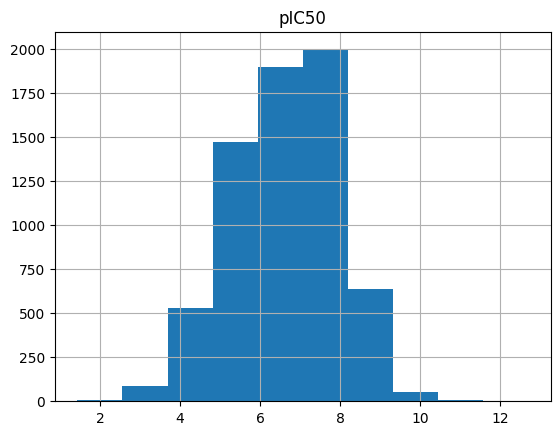

In [40]:
output_df.hist(column="pIC50")

[Say something about the distribution of pIC50 values]

In the next steps, a column for RDKit molecule objects will be added to the dataframe to look at the structures with the highest pIC50 values

In [41]:
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

Sort molecules by pIC50

In [42]:
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

Reset index

In [43]:
output_df.reset_index(drop=True, inplace=True)

In [44]:
output_df.head(3)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,<rdkit.Chem.rdchem.Mol object at 0x7fccced2ba60>
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,<rdkit.Chem.rdchem.Mol object at 0x7fccced2bac0>
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,<rdkit.Chem.rdchem.Mol object at 0x7fccced2bb80>


Drop the ROMol column (is to much to save)

Save the data as csv file

In [45]:
output_df.to_csv(DATA/"BACE_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,<rdkit.Chem.rdchem.Mol object at 0x7fccced2ba60>
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,<rdkit.Chem.rdchem.Mol object at 0x7fccced2bac0>
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,<rdkit.Chem.rdchem.Mol object at 0x7fccced2bb80>
3,CHEMBL3955051,0.0018,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,<rdkit.Chem.rdchem.Mol object at 0x7fccced2bb20>
4,CHEMBL3936264,0.0057,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,<rdkit.Chem.rdchem.Mol object at 0x7fccced2ba00>


For promising compounds in not only the potency, but also the drug-likeness important. In the next part the orally bioavailablity of these compounds will be examined using Lipinski's rule-of-5. 